# Evaluation Notebook

I create a standardized `.jsonl` format. Each line of the `.jsonl` file is a dictionary with the following information:
 - `image`: A (potentially relative) path to the target image. Relative paths are used when standard benchmarks are used, and absolute paths vary between users.
 - `width`, `height`: The dimensions of the image.
 - `references`: A list of the format:
    - `caption`: A caption describing the object.
    - `xyxy`: A bounding box, in xyxy format, in pixels.
 - `known_absent_captions`: A list of object text descriptions that are known to not be in the image.

Each of the detection APIs will follow a standardized format.
Input:
 - `image`: An image
 - `captions`: A batch of captions to test for
Output: A list of object detections, each with:
   - `xyxy`: A bounding box, in xyxy format, in pixels.
   - `logits`: A list of binary logits (representing log\[P(true)/P(false)\]).
   - `scores`: A list of normalized (0...1) scores for each of the captions. These may not sum to 1 if none of the captions match, or if multiple captions are not mutually exclusive in some way. They are calculated directly by applying the sigmoid function to the `logits` output.
   - `caption`: An optional string which includes the caption generated for that chosen object.

Providing logit and score outputs for each detection allows us to calculate average precision for false negatives.


In [121]:
%load_ext autoreload
%autoreload 2

from detect_cas import owlv2, get_caption_logit, generate_caption_phi3
import numpy as np
from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

# This wrapper makes it easy to generate captions.
class PaliGemmaWrapper:
    def __init__(self, base_model_id, finetune_checkpoint=None, device="cuda"):
        token = os.environ['HUGGINGFACE_ACCESS_TOKEN']
        model = PaliGemmaForConditionalGeneration.from_pretrained(
            (finetune_checkpoint or base_model_id),
            torch_dtype=torch.bfloat16,
            token=token,
            device_map=device,
        )
        processor = PaliGemmaProcessor.from_pretrained(base_model_id, token=token)
        
        self.model = model
        self.model = torch.compile(self.model)
        self.processor = processor
        
    def generate_caption(self, image, bbox):
        # Tokenize the bounding box.
        (x1, y1, x2, y2) = bbox
        # Scale to integer coordinated in a 1024x1024 image.
        x1_quantized = int((x1 / image.width) * 1024)
        y1_quantized = int((y1 / image.height) * 1024)
        x2_quantized = int((x2 / image.width) * 1024)
        y2_quantized = int((y2 / image.height) * 1024)
        bbox_tokenized = f"<loc{x1_quantized:04d}><loc{y1_quantized:04d}><loc{x2_quantized:04d}><loc{y2_quantized:04d}>"
        
        prefix = f"Describe {bbox_tokenized}"
        
        inputs = self.processor(prefix, image.convert("RGB"), return_tensors="pt").to("cuda")
        with torch.no_grad():
            output = self.model.generate(**inputs, max_new_tokens=32)
            caption = self.processor.decode(output[0], skip_special_tokens=True)[len(prefix):]
        
        return caption

# Uses OwlV2's raw text embedding similarity, and chooses the object detection with the highest similarity score.
class OwlV2Selector:
    def __init__(self, owlv2):
        self.owlv2 = owlv2
        
    def detect(self, image, captions):
        return self.owlv2(image, captions)

# Uses object detections from OwlV2, and physical attributes from phi-3-vision, to select the target object.
class CropAndCaptionSelector:
    def __init__(self, owlv2):
        self.owlv2 = owlv2
        
    def detect(self, image, targets):
        preliminary_detections = self.owlv2(image, targets)
        generated_captions = [generate_caption_phi3(image, detection['xyxy']) for detection in preliminary_detections]
        detections = []
        for i in range(len(preliminary_detections)):
            logits = np.array([get_caption_logit(generated_captions[i], target) for target in targets])
            detection = {
                "xyxy": preliminary_detections[i]["xyxy"],
                "logits": logits,
                "scores": 1/(1 + np.exp(-logits)),
                "caption": generated_captions[i],
            }
            detections.append(detection)
            
        return detections

"""
Uses object detections from OwlV2, and a finetuned Pali 3 model to generate captions for the corresponding object detections.

In the longer term... a nice paper would be to do this (the object detection, and reasoning), end-to-end. For example:

```
<image>

<user> Locate the person in the white shirt. </user>

<agent>

Let's first locate all the people in the image.
<bbox 1>: A person with a white shirt.
<bbox 2>: ...

The most likely match for the criteria is <bbox 1>.

</agent>

```
"""

class ChainOfThoughtSelector:
    """
    Very similar to the crop-and-caption selector, just uses a different captioning backend.
    """
    def __init__(self, owlv2, vlm: PaliGemmaWrapper):
        self.owlv2 = owlv2
        self.vlm = vlm
        
    def detect(self, image, targets, cached_preliminary_detections_and_generated_captions=None):
        if cached_preliminary_detections_and_generated_captions is None:
            preliminary_detections = self.owlv2(image, targets)
            generated_captions = [self.vlm.generate_caption(image, detection['xyxy']) for detection in preliminary_detections]
        else:
            preliminary_detections, generated_captions = cached_preliminary_detections_and_generated_captions
        detections = []
        for i in range(len(preliminary_detections)):
            logits = np.array([get_caption_logit(generated_captions[i], target) for target in targets])
            detection = {
                "xyxy": preliminary_detections[i]["xyxy"],
                "logits": logits,
                "scores": 1/(1 + np.exp(-logits)),
                "caption": generated_captions[i],
            }
            detections.append(detection)
            
        return detections


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Processing `.jsonl` datasets

Now, let's create a pipeline through which we can process validation datasets and generate nice metrics (e.g, AP, AP50, AP75). I don't think AP, AP50, and AP75 should deviate very much, because OwlV2 is already pretty good at "objectness"; I would be more concerned about false positives and false negatives for specific classes.

Let's first generate one for OCID-Ref.


In [4]:
import json

def load_jsonl(path):
    with open(path) as f:
        rows = [json.loads(row.strip()) for row in f.readlines()]
    return rows

ocidref_eval = load_jsonl('ocid-ref-val.eval.jsonl')
ocidref_root = '/scratch/gsk6me/WORLDMODELS/OCID-dataset'

In [9]:
# From pycocotools.
def calculate_iou(xyxy1, xyxy2):
    xa, ya, x2a, y2a = xyxy1
    xb, yb, x2b, y2b = xyxy2
    
    # innermost left x
    xi = max(xa, xb)
    # innermost right x
    x2i = min(x2a, x2b)
    # same for y
    yi = max(ya, yb)
    y2i = min(y2a, y2b)

    # calculate areas
    Aa = max(x2a - xa, 0) * max(y2a - ya, 0)
    Ab = max(x2b - xb, 0) * max(y2b - yb, 0)
    Ai = max(x2i - xi, 0) * max(y2i - yi, 0)
    return Ai / (Aa + Ab - Ai)

# Each caption has a single ground truth reference.
# Multiple captions can belong to the same reference.
def identify_tp_fp_fn(true_references, pred_references, iou_threshold=0.5):
    # Match predictions to ground truth values.
    # Iterate over detections.
    ious = {
        (di, gi): calculate_iou(true_references[gi]['xyxy'], pred_references[di]['xyxy'])
        for gi in range(len(true_references))
        for di in range(len(pred_references))
    }
    
    matches = np.zeros(len(true_references), dtype=int) - 1
    match_scores = np.zeros(len(true_references))
    
    # Here, we assume that there is a unique object for each caption.
    # Iterate over different captions, treating them as separate classes.
    false_positive_scores = []
    true_positive_scores = []
    for caption_i in range(len(true_references)):
        for di, dref in enumerate(pred_references):
            # Treat only the argmax as the label.
            if (dref['scores'][caption_i] != dref['scores'].max()):
                continue
                
            # Determine whether true positive or false positive.
            is_match = ious[di, caption_i] >= iou_threshold
            score = dref['scores'][caption_i]
            if is_match:
                true_positive_scores.append(score)
            else:
                false_positive_scores.append(score)
            
#         if best_match_score_i != -1:
#             matches[best_match_score_i] = di
#             match_scores[best_match_score_i] = best_match_score
#     for di, dref in enumerate(pred_references):
#         best_match_score = 0
#         best_match_score_i = -1
#         # Identify the best-matching object.
#         for gi, gref in enumerate(true_references):
#             # Check if already matched or does not reach threshold.
#             if (matches[gi] != -1) or (ious[di, gi] < iou_threshold):
#                 continue

#             # dref['scores'][gi] is the score corresponding to this caption.
#             score = dref['scores'][gi]
#             if score > best_match_score:
#                 best_match_score = score
#                 best_match_score_i = gi
                
#         if best_match_score_i != -1:
#             matches[best_match_score_i] = di
#             match_scores[best_match_score_i] = best_match_score
    
    num_false_negatives = (matches == -1).sum()
    
    return (true_positive_scores, false_positive_scores, [0] * num_false_negatives)


In [ ]:
import PIL.Image
import os
import tqdm

owlv2_selector = OwlV2Selector(owlv2)
detections = []

for row in tqdm.tqdm(ocidref_eval, desc="Generating detections."):
    image = PIL.Image.open(os.path.join(ocidref_root, row['image']))
    captions = [ref['caption'] for ref in row['references']]
    true_references = row['references']
    pred_references = owlv2_selector.detect(image, captions)
    
    detections.append(pred_references)


In [12]:
import torch
torch.save(detections, "eval_outputs/ocid-ref-valid.owlv2.eval.pt")

In [ ]:
# Now, we calculate AP.
from sklearn.metrics import average_precision_score
import tqdm

iou_results = []

for iou_threshold in [0.5, 0.75]:
    trues = []
    scores = []
    for (pred_references, row) in tqdm.tqdm(zip(detections, ocidref_eval), desc='Calculating', total=len(detections)):
        true_references = row['references']
        for i in range(len(pred_references)):
            pred_references[i]['xyxy'] = pred_references[i]['box'].cpu().numpy()
        tp_scores, fp_scores, fn_scores = identify_tp_fp_fn(true_references, pred_references, iou_threshold=iou_threshold)
        trues.extend([1] * len(tp_scores))
        scores.extend(score.item() for score in tp_scores)
        trues.extend([0] * len(fp_scores))
        scores.extend(score.item() for score in fp_scores)
        trues.extend([1] * len(fn_scores))
        scores.extend(fn_scores)
    iou_results.append((trues, scores))

In [34]:
for (trues, scores), name in zip(iou_results, ['AP50', 'AP75']):
    print(f"{name}:", average_precision_score(trues, scores))

AP50: 0.5688324488826961
AP75: 0.5646491817927116


In [92]:
import dotenv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dotenv.load_dotenv("/scratch/gsk6me/WORLDMODELS/crl-online-policies/.env")
paligemma_wrapper = PaliGemmaWrapper(
    'google/paligemma-3b-mix-224',
    './paligemma_object_captioner_pretrained_finetune_ocidref-train/checkpoint-16240'
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


In [97]:
row['references'][0]['caption'], row['references'][0]['caption'][:-1].lower()

('The box behind and on the bottom-right of the vegetable.',
 'the box behind and on the bottom-right of the vegetable')

In [ ]:
import PIL.Image
import os
import tqdm

# selector = CropAndCaptionSelector(owlv2)
selector = ChainOfThoughtSelector(owlv2, paligemma_wrapper)
detections = []

for row in tqdm.tqdm(ocidref_eval, desc="Generating detections."):
    image = PIL.Image.open(os.path.join(ocidref_root, row['image']))
    captions = [ref['caption'][:-1].lower() for ref in row['references']]
    true_references = row['references']
    pred_references = selector.detect(image, captions)
    
    detections.append(pred_references)

In [99]:
# import torch
# torch.save(detections, "eval_outputs/ocid-ref-valid.paligemma.eval.pt")

In [126]:
# go through and recalculate logits

for i, row in enumerate(tqdm.tqdm(ocidref_eval, desc="Recalculating logits.")):
    image = PIL.Image.open(os.path.join(ocidref_root, row['image']))
    captions = [ref['caption'][:-1].lower() for ref in row['references']]
    true_references = row['references']
    pred_references = detections[i]
    targets = captions
    for ref in pred_references:
        ref['logits'] = np.array([get_caption_logit(ref['caption'], target) for target in targets])
        ref['scores'] = 1/(1 + np.exp(-ref['logits']))


Recalculating logits.:   3%|▎         | 60/1963 [05:55<3:07:41,  5.92s/it]


KeyboardInterrupt: 

In [120]:
detections_OLD = detections

Generating detections.:   0%|          | 0/1963 [00:00<?, ?it/s]

[477.71002 177.10962 541.9243  232.63818] 
The sphere yellow ball on the front left of the orange fruit. The black cup on the rear right of the sphere white ball.
Best IOU caption: The sphere yellow ball on the front right of the sphere white ball.
Question: An object is described as a beige hand towel on the rear left of the green white marker. Could this be 
the sphere yellow ball on the front left of the orange fruit? Answer:
The beige hand towel on the rear left of the green white marker. -0.453125 
Question: An object is described as a sphere yellow ball on the front right of the sphere white ball. Could this be 
the sphere yellow ball on the front left of the orange fruit? Answer:
The sphere yellow ball on the front right of the sphere white ball. 0.390625 <--
Question: An object is described as a shampoo on the front left of the cereal box. Could this be 
the sphere yellow ball on the front left of the orange fruit? Answer:
The shampoo on the front left of the cereal box. -0.015

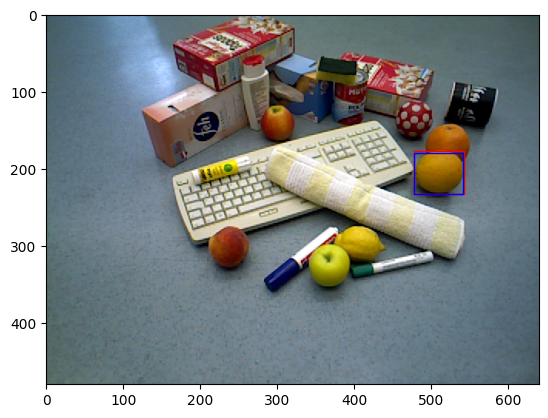

Generating detections.:   0%|          | 1/1963 [00:01<33:56,  1.04s/it]

[223.56416 241.70386 257.2883  274.79312] 
The tomato on the front left of the apple. The red plastic ball on the Upper-left of the navy marker.
Best IOU caption: The pen in front of the can.
Question: An object is described as a pen in front of the can. Could this be 
the tomato on the front left of the apple? Answer:
The pen in front of the can. -0.03125 <--
Question: An object is described as a navy pen at down side. Could this be 
the tomato on the front left of the apple? Answer:
The navy pen at down side. -0.34375 
Question: An object is described as a pen at lower-right side. Could this be 
the tomato on the front left of the apple? Answer:
The pen at lower-right side. -0.265625 
Question: An object is described as a ball on the rear left of the can. Could this be 
the tomato on the front left of the apple? Answer:
The ball on the rear left of the can. -0.234375 
Question: An object is described as a red plastic ball on the upper-left of the navy marker. Could this be 
the tomat

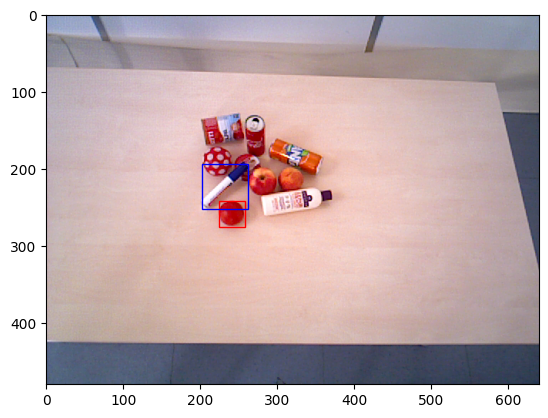

Generating detections.:   0%|          | 2/1963 [00:01<25:40,  1.27it/s]

[241.10666 276.9853  354.83307 374.23822] 
The beige hand towel on the front right of the navy marker. The navy marker in the front.
Best IOU caption: The white beige hand towel.
Question: An object is described as a box in the front. Could this be 
the beige hand towel on the front right of the navy marker? Answer:
The box in the front. 0.265625 
Question: An object is described as a food bag on the rear right of the kleenex. Could this be 
the beige hand towel on the front right of the navy marker? Answer:
The food bag on the rear right of the kleenex. 0.046875 
Question: An object is described as a white beige hand towel. Could this be 
the beige hand towel on the front right of the navy marker? Answer:
The white beige hand towel. 0.59375 <--
Question: An object is described as a sponge behind and on the top-right of the hand towel. Could this be 
the beige hand towel on the front right of the navy marker? Answer:
The sponge behind and on the top-right of the hand towel. 0.0625 
Que

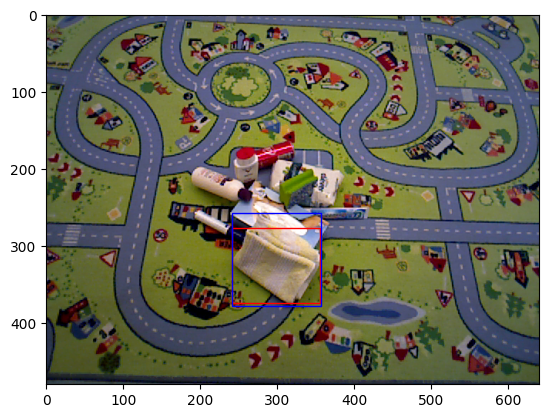

Generating detections.:   0%|          | 3/1963 [00:02<23:11,  1.41it/s]

[342.75153   92.518776 569.8752   199.03473 ] 
The black smooth plastic object. The box on the rear left of the keyboard.
Best IOU caption: The box on the rear left of the keyboard.
Question: An object is described as a box on the rear left of the keyboard. Could this be 
the black smooth plastic object? Answer:
The box on the rear left of the keyboard. 0.609375 


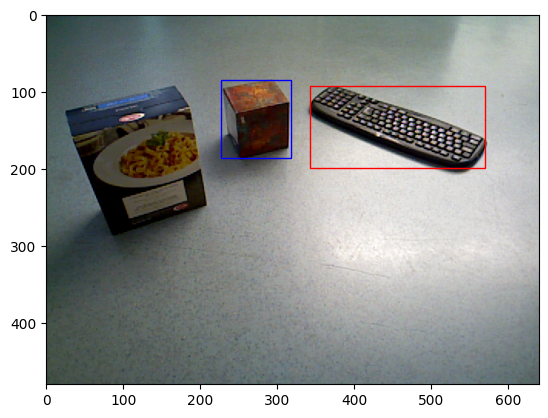

Generating detections.:   0%|          | 4/1963 [00:02<17:12,  1.90it/s]

[ 94.93692 232.26212 139.13292 268.24887] 
The lime fruit on the front left of the cylinder orange can. The lime object.
Best IOU caption: The lime object.
Question: An object is described as a can on the rear right of the ball. Could this be 
the lime fruit on the front left of the cylinder orange can? Answer:
The can on the rear right of the ball. 0.171875 
Question: An object is described as a black box on the right. Could this be 
the lime fruit on the front left of the cylinder orange can? Answer:
The black box on the right. 0.0625 
Question: An object is described as a fruit on the rear left. Could this be 
the lime fruit on the front left of the cylinder orange can? Answer:
The fruit on the rear left. 0.1484375 
Question: An object is described as a glue stick on the front right. Could this be 
the lime fruit on the front left of the cylinder orange can? Answer:
The glue stick on the front right. -0.296875 
Question: An object is described as a black food box. Could this be 
the

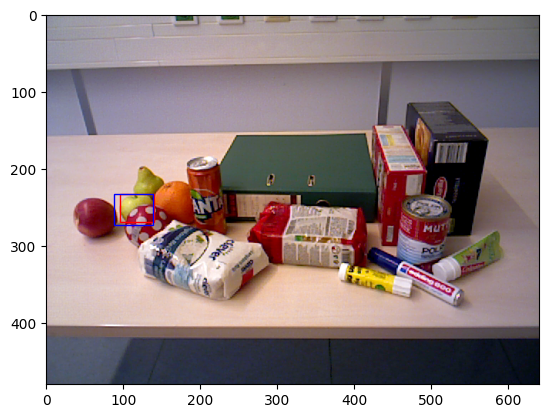

Generating detections.:   0%|          | 5/1963 [00:03<20:20,  1.60it/s]

[166.35178 315.85968 244.15298 376.93457] 
The red bag on the rear left of the cuboid yellow box. The red object.
Best IOU caption: The red instant noodles.
Question: An object is described as a green white pen on the rear left of the navy pen. Could this be 
the red bag on the rear left of the cuboid yellow box? Answer:
The green white pen on the rear left of the navy pen. 0.015625 
Question: An object is described as a white blue object. Could this be 
the red bag on the rear left of the cuboid yellow box? Answer:
The white blue object. 0.40625 
Question: An object is described as a box on the rear left of the bag. Could this be 
the red bag on the rear left of the cuboid yellow box? Answer:
The box on the rear left of the bag. 0.453125 
Question: An object is described as a cuboid yellow box on the front right. Could this be 
the red bag on the rear left of the cuboid yellow box? Answer:
The cuboid yellow box on the front right. 0.296875 
Question: An object is described as a red in

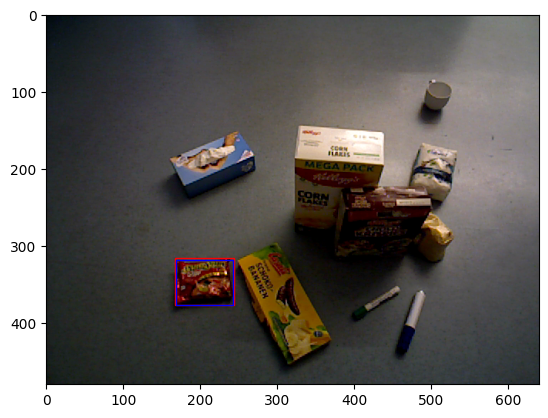

Generating detections.:   0%|          | 5/1963 [00:03<24:21,  1.34it/s]


In [119]:
# Display a set of detections
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for i, row in enumerate(tqdm.tqdm(ocidref_eval, desc="Generating detections.")):
    image = PIL.Image.open(os.path.join(ocidref_root, row['image']))
    plt.imshow(image)
    ax = plt.gca()
    
    for pred_ref in detections[i]:
        x1, y1, x2, y2 = pred_ref['xyxy']
        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, color='red', fill=False))
        print(pred_ref['xyxy'], pred_ref['caption'], row['references'][np.argmax(pred_ref['logits'])]['caption'])
        
        best_iou = 0
        best_iou_i = -1
        for j, gt_ref in enumerate(row['references']):
            iou = calculate_iou(pred_ref['xyxy'], gt_ref['xyxy'])
            if iou > best_iou:
                best_iou = iou
                best_iou_i = j
        
        m = row['references'][best_iou_i]
        x1, y1, x2, y2 = m['xyxy']
        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, color='blue', fill=False))
        
        print("Best IOU caption:", m['caption'])
        
        # Now, go through the captions, and manually calculate logits.
        for j, gt_ref in enumerate(row['references']):
            logit = get_caption_logit(gt_ref['caption'], pred_ref['caption'])
            print(gt_ref['caption'], logit, '<--' if j == best_iou_i else '')
        
        break
        
    plt.show()
    
    if i >= 5:
        break



In [127]:
# Now, we calculate AP.
from sklearn.metrics import average_precision_score
import tqdm

iou_results = []

for iou_threshold in [0.5, 0.75]:
    trues = []
    scores = []
    for (pred_references, row) in tqdm.tqdm(zip(detections[:60], ocidref_eval), desc='Calculating', total=len(detections)):
        true_references = row['references']
        # for i in range(len(pred_references)):
        #     pred_references[i]['xyxy'] = pred_references[i]['xyxy'].cpu().numpy()
        tp_scores, fp_scores, fn_scores = identify_tp_fp_fn(true_references, pred_references, iou_threshold=iou_threshold)
        trues.extend([1] * len(tp_scores))
        scores.extend(score.item() for score in tp_scores)
        trues.extend([0] * len(fp_scores))
        scores.extend(score.item() for score in fp_scores)
        trues.extend([1] * len(fn_scores))
        scores.extend(fn_scores)
    iou_results.append((trues, scores))

Calculating:   3%|▎         | 60/1963 [00:00<00:11, 159.25it/s]


In [128]:
for (trues, scores), name in zip(iou_results, ['AP50', 'AP75']):
    print(f"{name}:", average_precision_score(trues, scores))

AP50: 0.5878371888388169
AP75: 0.5831326699099734
